In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")
from tqdm.notebook import tqdm
print("Done")

Done


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df = pd.read_csv("textData.csv")
df.head()

,tagline,title
0,Pure electric motorcycle proves a powerful alt...,Join the Electric Revolution!!!
1,Send Me to Haiti...I'm needed there!,Relief Trip to Haiti
2,Haiti Relief Mission to Leogane,"Out To Reach Leogane, Haiti 2010"
3,My third book on Fezziwig Press.,The Transpersonal Papers: 1861-2010
4,Homeless Veterans Transitional Housing Develop...,Homeless Veterans need a Hand UP not Hand Out!


In [3]:
tagline = pd.DataFrame(df.tagline).reset_index()
title = pd.DataFrame(df.title).reset_index()
tagline.head()

,index,tagline
0,0,Pure electric motorcycle proves a powerful alt...
1,1,Send Me to Haiti...I'm needed there!
2,2,Haiti Relief Mission to Leogane
3,3,My third book on Fezziwig Press.
4,4,Homeless Veterans Transitional Housing Develop...


## Sentiment Score Predicition ##
Previously, we uses the VADER model to predict the sentiment score. It uses the "bag of the words" approach where Stop words are removed and each word is scored and combined to a total score.
We will also attempt to use the distill Bert model for predicting the sentiment score. It is a model derived from the original BERT model. It has slight degradation from BERT, but perform relatively efficiently. We will use it to compare the results derived from VADER prediction.
References: 
1) https://towardsdatascience.com/bert-roberta-distilbert-xlnet-which-one-to-use-3d5ab82ba5f8

2) https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial


In [ ]:
## AN EXAMPLE ##

In [4]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("I am so happy!!!")

{'neg': 0.0, 'neu': 0.291, 'pos': 0.709, 'compound': 0.7067}

In [5]:
sia.polarity_scores("This is so sad, very sad..")

{'neg': 0.444, 'neu': 0.556, 'pos': 0.0, 'compound': -0.6113}

In [6]:
# Fitting To model
res = {}

for i, row in tqdm(tagline.iterrows(), total=len(tagline)):
    text = row['tagline']
    myid = row['index']
    res[myid] = sia.polarity_scores(text)


  0%|          | 0/20618 [00:00<?, ?it/s]

In [7]:
vaders = pd.DataFrame(res).T
vaders.head()

,neg,neu,pos,compound
0,0.0,0.641,0.359,0.4215
1,0.0,1.000,0.000,0.0000
2,0.0,0.563,0.437,0.4767
3,0.0,1.000,0.000,0.0000
4,0.0,1.000,0.000,0.0000


In [8]:
vaders = vaders.reset_index()


In [11]:
vaders = vaders.merge(tagline,how='left')
vaders.head()

,index,neg,neu,pos,compound,tagline
0,0,0.0,0.641,0.359,0.4215,Pure electric motorcycle proves a powerful alt...
1,1,0.0,1.000,0.000,0.0000,Send Me to Haiti...I'm needed there!
2,2,0.0,0.563,0.437,0.4767,Haiti Relief Mission to Leogane
3,3,0.0,1.000,0.000,0.0000,My third book on Fezziwig Press.
4,4,0.0,1.000,0.000,0.0000,Homeless Veterans Transitional Housing Develop...


In [12]:
vaders.isnull().sum()

index       0
neg         0
neu         0
pos         0
compound    0
tagline     0
dtype: int64

In [13]:
import seaborn as sns

<AxesSubplot:xlabel='compound', ylabel='Count'>

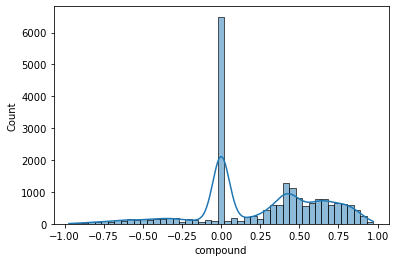

In [14]:
sns.histplot(data=vaders,x='compound',kde=True)

We see that most of our data were predicted with a 0 compound score, meaning that they tend to neutral. This could likely be due to the datasets or perhaps is the VADER models is not doing a good job in the prediction of sentiment score. We will use the distill BERT model to try to model the prediction. It will only have 2 classes in the output, the positive score and the negative score (which summation of both adds to 1).

In [15]:
from transformers import pipeline

In [22]:
sent_pipeline = pipeline("sentiment-analysis", return_all_scores=True)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
C:\Users\user\anaconda3\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [30]:
sent_pipeline("Send Me to Haiti...I'm needed there!")

[[{'label': 'NEGATIVE', 'score': 0.05961787700653076},
  {'label': 'POSITIVE', 'score': 0.9403821229934692}]]

We see a results difference here. This could be due to VADER not doing its prediction properly. However, we should not jump into the conclusion based on 1 data point.

In [31]:
res = {}

for i, row in tqdm(tagline.iterrows(), total=len(tagline)):
    text = row['tagline']
    myid = row['index']
    res[myid] = sent_pipeline(text)

  0%|          | 0/20618 [00:00<?, ?it/s]

In [35]:
distilBert = pd.DataFrame(res).T
distilBert = distilBert.rename(columns= {0:"distillBert"})

In [37]:
distillBert = distilBert.reset_index()

In [38]:
distillBert.head()

,index,distillBert
0,0,"[{'label': 'NEGATIVE', 'score': 0.000377067364..."
1,1,"[{'label': 'NEGATIVE', 'score': 0.059617877006..."
2,2,"[{'label': 'NEGATIVE', 'score': 0.088564030826..."
3,3,"[{'label': 'NEGATIVE', 'score': 0.491195201873..."
4,4,"[{'label': 'NEGATIVE', 'score': 0.760683655738..."


In [39]:
distillBert = distillBert.merge(tagline,how='left')
distillBert

,index,distillBert,tagline
0,0,"[{'label': 'NEGATIVE', 'score': 0.000377067364...",Pure electric motorcycle proves a powerful alt...
1,1,"[{'label': 'NEGATIVE', 'score': 0.059617877006...",Send Me to Haiti...I'm needed there!
2,2,"[{'label': 'NEGATIVE', 'score': 0.088564030826...",Haiti Relief Mission to Leogane
3,3,"[{'label': 'NEGATIVE', 'score': 0.491195201873...",My third book on Fezziwig Press.
4,4,"[{'label': 'NEGATIVE', 'score': 0.760683655738...",Homeless Veterans Transitional Housing Develop...
...,...,...,...
20613,20613,"[{'label': 'NEGATIVE', 'score': 0.970423877239...",Trans filmmaker making queer documentaries. It...
20614,20614,"[{'label': 'NEGATIVE', 'score': 0.010302940383...","Help us finance Every Stone, our first EP!"
20615,20615,"[{'label': 'NEGATIVE', 'score': 0.000269847078...","Benefits Save Venice, helps to protect Venice'..."
20616,20616,"[{'label': 'NEGATIVE', 'score': 0.001673236023...",Hi


In [41]:
final = distillBert.merge(vaders,how = 'left')

,index,distillBert,tagline,neg,neu,pos,compound
0,0,"[{'label': 'NEGATIVE', 'score': 0.000377067364...",Pure electric motorcycle proves a powerful alt...,0.0,0.641,0.359,0.4215
1,1,"[{'label': 'NEGATIVE', 'score': 0.059617877006...",Send Me to Haiti...I'm needed there!,0.0,1.000,0.000,0.0000
2,2,"[{'label': 'NEGATIVE', 'score': 0.088564030826...",Haiti Relief Mission to Leogane,0.0,0.563,0.437,0.4767
3,3,"[{'label': 'NEGATIVE', 'score': 0.491195201873...",My third book on Fezziwig Press.,0.0,1.000,0.000,0.0000
4,4,"[{'label': 'NEGATIVE', 'score': 0.760683655738...",Homeless Veterans Transitional Housing Develop...,0.0,1.000,0.000,0.0000


In [42]:
final = final.rename(columns = {'neg':'neg_tag_vader','neu':'neu_tag_vader','pos':'pos_tag_vader','compound':'compound_tag_vader'})
final.head()

,index,distillBert,tagline,neg_tag_vader,neu_tag_vader,pos_tag_vader,compound_tag_vader
0,0,"[{'label': 'NEGATIVE', 'score': 0.000377067364...",Pure electric motorcycle proves a powerful alt...,0.0,0.641,0.359,0.4215
1,1,"[{'label': 'NEGATIVE', 'score': 0.059617877006...",Send Me to Haiti...I'm needed there!,0.0,1.000,0.000,0.0000
2,2,"[{'label': 'NEGATIVE', 'score': 0.088564030826...",Haiti Relief Mission to Leogane,0.0,0.563,0.437,0.4767
3,3,"[{'label': 'NEGATIVE', 'score': 0.491195201873...",My third book on Fezziwig Press.,0.0,1.000,0.000,0.0000
4,4,"[{'label': 'NEGATIVE', 'score': 0.760683655738...",Homeless Veterans Transitional Housing Develop...,0.0,1.000,0.000,0.0000


In [ ]:
 ## APPLYING THE SAME SENTIMENT SCORE PREDICTION TO TITLE ##

In [43]:
title

,index,title
0,0,Join the Electric Revolution!!!
1,1,Relief Trip to Haiti
2,2,"Out To Reach Leogane, Haiti 2010"
3,3,The Transpersonal Papers: 1861-2010
4,4,Homeless Veterans need a Hand UP not Hand Out!
...,...,...
20613,20613,Totally Gay Productions
20614,20614,Lady Crow debut EP
20615,20615,"JOSA, the ultimate Venice-Inspired bracelet"
20616,20616,My Campaign Title


In [44]:
## vaders
res = {}

for i, row in tqdm(title.iterrows(), total=len(title)):
    text = row['title']
    myid = row['index']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/20618 [00:00<?, ?it/s]

In [45]:
vaders_title = pd.DataFrame(res).T
vaders_title.head()

,neg,neu,pos,compound
0,0.0,0.494,0.506,0.4724
1,0.0,0.492,0.508,0.4767
2,0.0,0.820,0.180,0.0258
3,0.0,1.000,0.000,0.0000
4,0.0,0.473,0.527,0.7712


In [46]:
vaders_title = vaders_title.reset_index()
vaders_title = vaders_title.rename(columns = {'neg':'neg_ti_vader','neu':'neu_ti_vader','pos':'pos_ti_vader','compound':'compound_ti_vader'})
vaders_title.head()

,index,neg_ti_vader,neu_ti_vader,pos_ti_vader,compound_ti_vader
0,0,0.0,0.494,0.506,0.4724
1,1,0.0,0.492,0.508,0.4767
2,2,0.0,0.820,0.180,0.0258
3,3,0.0,1.000,0.000,0.0000
4,4,0.0,0.473,0.527,0.7712


In [47]:
## distill Bert
res = {}

for i, row in tqdm(title.iterrows(), total=len(title)):
    text = row['title']
    myid = row['index']
    res[myid] = sent_pipeline(text)

  0%|          | 0/20618 [00:00<?, ?it/s]

In [48]:
distillBert_title = pd.DataFrame(res).T.reset_index()
distillBert_title.head()

,index,0
0,0,"[{'label': 'NEGATIVE', 'score': 0.001304742763..."
1,1,"[{'label': 'NEGATIVE', 'score': 0.005012538284..."
2,2,"[{'label': 'NEGATIVE', 'score': 0.004275542218..."
3,3,"[{'label': 'NEGATIVE', 'score': 0.026055615395..."
4,4,"[{'label': 'NEGATIVE', 'score': 0.978423297405..."


In [50]:
distillBert_title = distillBert_title.rename(columns = {0:"distillBert_ti"})
distillBert_title.head()

,index,distillBert_ti
0,0,"[{'label': 'NEGATIVE', 'score': 0.001304742763..."
1,1,"[{'label': 'NEGATIVE', 'score': 0.005012538284..."
2,2,"[{'label': 'NEGATIVE', 'score': 0.004275542218..."
3,3,"[{'label': 'NEGATIVE', 'score': 0.026055615395..."
4,4,"[{'label': 'NEGATIVE', 'score': 0.978423297405..."


In [53]:
distillBert_title = distillBert_title.merge(title,how='left')
distillBert_title.head()

,index,distillBert_ti,title
0,0,"[{'label': 'NEGATIVE', 'score': 0.001304742763...",Join the Electric Revolution!!!
1,1,"[{'label': 'NEGATIVE', 'score': 0.005012538284...",Relief Trip to Haiti
2,2,"[{'label': 'NEGATIVE', 'score': 0.004275542218...","Out To Reach Leogane, Haiti 2010"
3,3,"[{'label': 'NEGATIVE', 'score': 0.026055615395...",The Transpersonal Papers: 1861-2010
4,4,"[{'label': 'NEGATIVE', 'score': 0.978423297405...",Homeless Veterans need a Hand UP not Hand Out!


In [54]:
temp = vaders_title.merge(distillBert_title,how='left')
temp.head()

,index,neg_ti_vader,neu_ti_vader,pos_ti_vader,compound_ti_vader,distillBert_ti,title
0,0,0.0,0.494,0.506,0.4724,"[{'label': 'NEGATIVE', 'score': 0.001304742763...",Join the Electric Revolution!!!
1,1,0.0,0.492,0.508,0.4767,"[{'label': 'NEGATIVE', 'score': 0.005012538284...",Relief Trip to Haiti
2,2,0.0,0.820,0.180,0.0258,"[{'label': 'NEGATIVE', 'score': 0.004275542218...","Out To Reach Leogane, Haiti 2010"
3,3,0.0,1.000,0.000,0.0000,"[{'label': 'NEGATIVE', 'score': 0.026055615395...",The Transpersonal Papers: 1861-2010
4,4,0.0,0.473,0.527,0.7712,"[{'label': 'NEGATIVE', 'score': 0.978423297405...",Homeless Veterans need a Hand UP not Hand Out!


In [55]:
temp.isnull().sum()

index                0
neg_ti_vader         0
neu_ti_vader         0
pos_ti_vader         0
compound_ti_vader    0
distillBert_ti       0
title                0
dtype: int64

In [56]:
final.isnull().sum()

index                 0
distillBert           0
tagline               0
neg_tag_vader         0
neu_tag_vader         0
pos_tag_vader         0
compound_tag_vader    0
dtype: int64

In [57]:
final = final.merge(temp,how='left')
final.head()

,index,distillBert,tagline,neg_tag_vader,neu_tag_vader,pos_tag_vader,compound_tag_vader,neg_ti_vader,neu_ti_vader,pos_ti_vader,compound_ti_vader,distillBert_ti,title
0,0,"[{'label': 'NEGATIVE', 'score': 0.000377067364...",Pure electric motorcycle proves a powerful alt...,0.0,0.641,0.359,0.4215,0.0,0.494,0.506,0.4724,"[{'label': 'NEGATIVE', 'score': 0.001304742763...",Join the Electric Revolution!!!
1,1,"[{'label': 'NEGATIVE', 'score': 0.059617877006...",Send Me to Haiti...I'm needed there!,0.0,1.000,0.000,0.0000,0.0,0.492,0.508,0.4767,"[{'label': 'NEGATIVE', 'score': 0.005012538284...",Relief Trip to Haiti
2,2,"[{'label': 'NEGATIVE', 'score': 0.088564030826...",Haiti Relief Mission to Leogane,0.0,0.563,0.437,0.4767,0.0,0.820,0.180,0.0258,"[{'label': 'NEGATIVE', 'score': 0.004275542218...","Out To Reach Leogane, Haiti 2010"
3,3,"[{'label': 'NEGATIVE', 'score': 0.491195201873...",My third book on Fezziwig Press.,0.0,1.000,0.000,0.0000,0.0,1.000,0.000,0.0000,"[{'label': 'NEGATIVE', 'score': 0.026055615395...",The Transpersonal Papers: 1861-2010
4,4,"[{'label': 'NEGATIVE', 'score': 0.760683655738...",Homeless Veterans Transitional Housing Develop...,0.0,1.000,0.000,0.0000,0.0,0.473,0.527,0.7712,"[{'label': 'NEGATIVE', 'score': 0.978423297405...",Homeless Veterans need a Hand UP not Hand Out!


In [58]:
final.shape

(20618, 13)

In [59]:
final = final.rename(columns={'distillBert':'distillBert_tag'})
final.head()

,index,distillBert_tag,tagline,neg_tag_vader,neu_tag_vader,pos_tag_vader,compound_tag_vader,neg_ti_vader,neu_ti_vader,pos_ti_vader,compound_ti_vader,distillBert_ti,title
0,0,"[{'label': 'NEGATIVE', 'score': 0.000377067364...",Pure electric motorcycle proves a powerful alt...,0.0,0.641,0.359,0.4215,0.0,0.494,0.506,0.4724,"[{'label': 'NEGATIVE', 'score': 0.001304742763...",Join the Electric Revolution!!!
1,1,"[{'label': 'NEGATIVE', 'score': 0.059617877006...",Send Me to Haiti...I'm needed there!,0.0,1.000,0.000,0.0000,0.0,0.492,0.508,0.4767,"[{'label': 'NEGATIVE', 'score': 0.005012538284...",Relief Trip to Haiti
2,2,"[{'label': 'NEGATIVE', 'score': 0.088564030826...",Haiti Relief Mission to Leogane,0.0,0.563,0.437,0.4767,0.0,0.820,0.180,0.0258,"[{'label': 'NEGATIVE', 'score': 0.004275542218...","Out To Reach Leogane, Haiti 2010"
3,3,"[{'label': 'NEGATIVE', 'score': 0.491195201873...",My third book on Fezziwig Press.,0.0,1.000,0.000,0.0000,0.0,1.000,0.000,0.0000,"[{'label': 'NEGATIVE', 'score': 0.026055615395...",The Transpersonal Papers: 1861-2010
4,4,"[{'label': 'NEGATIVE', 'score': 0.760683655738...",Homeless Veterans Transitional Housing Develop...,0.0,1.000,0.000,0.0000,0.0,0.473,0.527,0.7712,"[{'label': 'NEGATIVE', 'score': 0.978423297405...",Homeless Veterans need a Hand UP not Hand Out!


In [60]:
final = final[['tagline','distillBert_tag','neg_tag_vader','neu_tag_vader','pos_tag_vader','compound_tag_vader',
              'title','distillBert_ti','neg_ti_vader','neu_ti_vader','pos_ti_vader','compound_ti_vader']]
final.head()

,tagline,distillBert_tag,neg_tag_vader,neu_tag_vader,pos_tag_vader,compound_tag_vader,title,distillBert_ti,neg_ti_vader,neu_ti_vader,pos_ti_vader,compound_ti_vader
0,Pure electric motorcycle proves a powerful alt...,"[{'label': 'NEGATIVE', 'score': 0.000377067364...",0.0,0.641,0.359,0.4215,Join the Electric Revolution!!!,"[{'label': 'NEGATIVE', 'score': 0.001304742763...",0.0,0.494,0.506,0.4724
1,Send Me to Haiti...I'm needed there!,"[{'label': 'NEGATIVE', 'score': 0.059617877006...",0.0,1.000,0.000,0.0000,Relief Trip to Haiti,"[{'label': 'NEGATIVE', 'score': 0.005012538284...",0.0,0.492,0.508,0.4767
2,Haiti Relief Mission to Leogane,"[{'label': 'NEGATIVE', 'score': 0.088564030826...",0.0,0.563,0.437,0.4767,"Out To Reach Leogane, Haiti 2010","[{'label': 'NEGATIVE', 'score': 0.004275542218...",0.0,0.820,0.180,0.0258
3,My third book on Fezziwig Press.,"[{'label': 'NEGATIVE', 'score': 0.491195201873...",0.0,1.000,0.000,0.0000,The Transpersonal Papers: 1861-2010,"[{'label': 'NEGATIVE', 'score': 0.026055615395...",0.0,1.000,0.000,0.0000
4,Homeless Veterans Transitional Housing Develop...,"[{'label': 'NEGATIVE', 'score': 0.760683655738...",0.0,1.000,0.000,0.0000,Homeless Veterans need a Hand UP not Hand Out!,"[{'label': 'NEGATIVE', 'score': 0.978423297405...",0.0,0.473,0.527,0.7712


In [ ]:
## OUTPUTTING OUR RESULTS INTO ANOTHER CSV FOR CLEANING, FURTHER EDA AND MODELLING

In [61]:
final.to_csv('text_results.csv',index = False)